# Time series data upload

Custom data that cannot easily be brought into the QA4SM netCDF format, e.g. because time stamps of the data vary by location, can be uploaded as time series data. We support two different formats for this:
- a zipped directory containing CSV files
- a zipped directory containing a gridded contiguous ragged `pynetcf` dataset

The former format is the easier format and recommended for most users. The latter is only necessary if the data is very big and CSV files are therefore not suitable.

## CSV time series format

The CSV files have to comply with the following conditions:
- The file names have to follow the pattern `<name>_lat=<lat_in_degree>_lon=<lon_in_degree>.csv`
- The files must have a single header row, and the first column must be a datetime index. This is the default output format when using `pandas.DataFrame.to_csv` on a data frame with a `pandas.DatetimeIndex` as index. To test whether your files comply with this format, you can read them with `pandas.read_csv(<fname>, index_col=0, parse_dates=True)` and see if the resulting data frame is in the right format.
- All files must have the same column names.

Optionally, an additional file with filename `metadata.yml` containing metadata for each variable can be added to the directory. The format should follow this example:
```
soil_moisture_1:
  long_name: soil moisture 1
  units: m^3/m^3
soil_moisture_2:
  long_name: soil moisture 2
  units: m^3/m^3
```

If you have a list of time series as `pandas.Series` or `pandas.DataFrame` and their associated coordinates, you can also use `qa4sm_preprocessing.utils.make_csv_dataset` to create a dataset in the correct format.

The following shows an example of how to create a such a dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

For now, assume that we have 3 timeseries (e.g. from in-situ data) from 3 locations in southern France, 

In [2]:
# timeseries 1: daily timestamps
index = pd.date_range("2020-01-01 12:00", "2020-12-31 12:00", freq="D")
data = np.random.randn(len(index))
ts1 = pd.Series(data, index=index, name="soil_moisture")
lat1 = 43.01
lon1 = 2.47

# timeseries 2: hourly timestamps, but shorter period
index = pd.date_range("2020-06-01", "2020-08-01", freq="H")
data = np.random.randn(len(index)) + 2
ts2 = pd.Series(data, index=index, name="soil_moisture")
lat2 = 43.11
lon2 = 2.8

# timeseries 3: irregular timestamps
index = pd.DatetimeIndex(np.datetime64("2020-01-01") + np.random.rand(1000) * np.timedelta64(365*24*60, "m"))
data = np.random.randn(len(index)) - 2
ts3 = pd.Series(data, index=index, name="soil_moisture")
lat3 = 43.4
lon3 = 1.35

In [3]:
ts1

2020-01-01 12:00:00   -1.045712
2020-01-02 12:00:00   -0.912192
2020-01-03 12:00:00    1.482758
2020-01-04 12:00:00   -0.650600
2020-01-05 12:00:00   -0.599310
                         ...   
2020-12-27 12:00:00   -0.663157
2020-12-28 12:00:00   -0.327255
2020-12-29 12:00:00    0.224074
2020-12-30 12:00:00   -0.823014
2020-12-31 12:00:00   -0.020694
Freq: D, Name: soil_moisture, Length: 366, dtype: float64

In [4]:
ts2

2020-06-01 00:00:00    1.504480
2020-06-01 01:00:00    2.104120
2020-06-01 02:00:00    1.546094
2020-06-01 03:00:00    3.115418
2020-06-01 04:00:00    2.223428
                         ...   
2020-07-31 20:00:00    2.145282
2020-07-31 21:00:00    2.576858
2020-07-31 22:00:00    1.374315
2020-07-31 23:00:00    1.712767
2020-08-01 00:00:00    2.599351
Freq: H, Name: soil_moisture, Length: 1465, dtype: float64

In [5]:
ts3

2020-02-08 00:23:00   -1.379468
2020-07-22 09:30:00   -2.534676
2020-03-04 08:15:00   -0.786444
2020-09-16 18:55:00   -2.182332
2020-06-18 15:01:00   -2.697276
                         ...   
2020-03-19 15:41:00   -4.262878
2020-01-16 15:22:00   -0.364268
2020-11-30 04:21:00    0.933662
2020-02-25 16:42:00   -1.324341
2020-11-01 19:09:00   -2.650013
Name: soil_moisture, Length: 1000, dtype: float64

<AxesSubplot:>

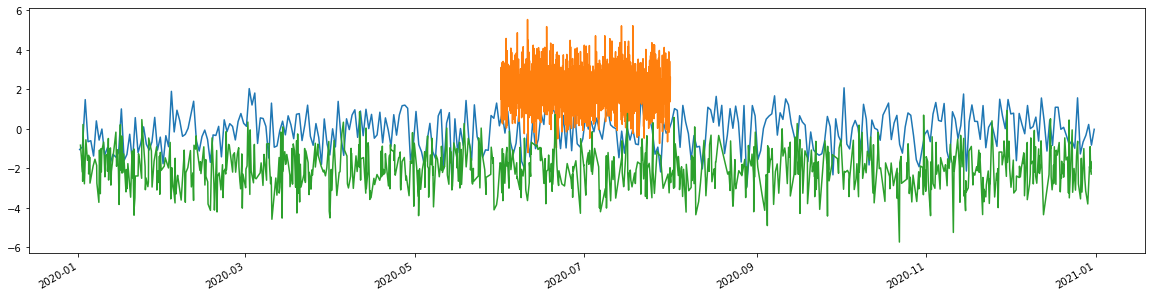

In [6]:
plt.figure(figsize=(20, 5))
ts1.plot()
ts2.plot()
ts3.plot()

We can also add some metadata, which is useful for creating plots in QA4SM.

In [7]:
metadata = {"soil_moisture": {"units": "m^3/m^3", "long_name": "Volumetric soil moisture"}}

Now we can create the CSV dataset from our time series using the function `qa4sm_preprocessing.utils.make_csv_dataset`. It takes as arguments lists of timeseries (as pandas.Series), lists of latitudes and longitudes, a directory name (data is written to this directory), a name of the dataset (as prefix for the CSV files), and optionally metadata.

By default, `make_csv_dataset` only selects timeseries that are close to ISMN stations. For this, an additional argument, the search radius in km, has to be passed to the function as well. Optionally, this can be turned off by passing `only_ismn=False`, and other locations can be used for selecting the timeseries (using the `only` keyword argument, more info in the documentation).

In this example, we chose coordinates close to the ISMN stations SMOSMANIA-Mouthoumet, SMOSMANIA-Lezignan-Corbieres, and COSMOS-Touluse, and we choose a 25 km search radius.

In [8]:
from qa4sm_preprocessing.utils import make_csv_dataset

lats = [lat1, lat2, lat3]
lons = [lon1, lon2, lon3]
timeseries = [ts1, ts2, ts3]

make_csv_dataset(timeseries, lats, lons, "csv_soil_moisture", name="mydataset", metadata=metadata, radius=25)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [9]:
%ls csv_soil_moisture

 metadata.yml
'mydataset_gpi=0_lat=43.01_lon=2.47.csv'
'mydataset_gpi=1_lat=43.11_lon=2.8.csv'
'mydataset_gpi=2_lat=43.4_lon=1.35.csv'


As expected, we have now 3 CSV files and a `metadata.yml` file in our directory. We can test whether they conform to the format required by QA4SM by reading them with `pandas.read_csv`.

                     soil_moisture
2020-02-08 00:23:00      -1.379468
2020-07-22 09:30:00      -2.534676
2020-03-04 08:15:00      -0.786444
2020-09-16 18:55:00      -2.182332
2020-06-18 15:01:00      -2.697276
...                            ...
2020-03-19 15:41:00      -4.262878
2020-01-16 15:22:00      -0.364268
2020-11-30 04:21:00       0.933662
2020-02-25 16:42:00      -1.324341
2020-11-01 19:09:00      -2.650013

[1000 rows x 1 columns]
                     soil_moisture
2020-01-01 12:00:00      -1.045712
2020-01-02 12:00:00      -0.912192
2020-01-03 12:00:00       1.482758
2020-01-04 12:00:00      -0.650600
2020-01-05 12:00:00      -0.599310
...                            ...
2020-12-27 12:00:00      -0.663157
2020-12-28 12:00:00      -0.327255
2020-12-29 12:00:00       0.224074
2020-12-30 12:00:00      -0.823014
2020-12-31 12:00:00      -0.020694

[366 rows x 1 columns]
                     soil_moisture
2020-06-01 00:00:00       1.504480
2020-06-01 01:00:00       2.104120
2020-0

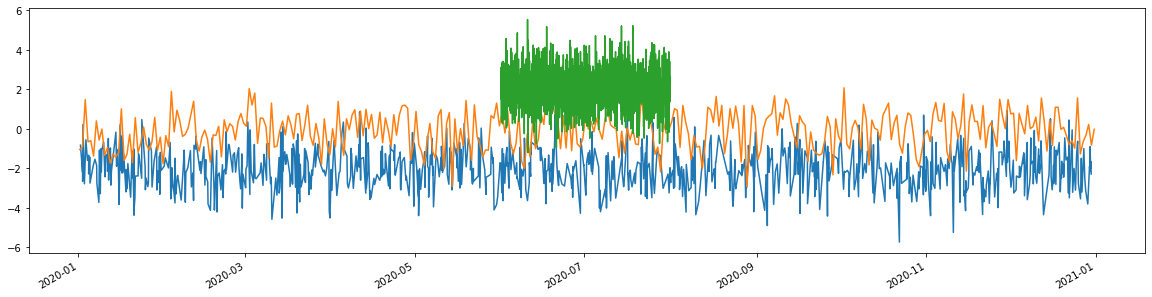

In [10]:
from pathlib import Path
import yaml

plt.figure(figsize=(20, 5))
for fname in Path("csv_soil_moisture").iterdir():
    if str(fname).endswith(".csv"):
        df = pd.read_csv(fname, index_col=0, parse_dates=True)
        df["soil_moisture"].plot()
        print(df)
    else:  # yaml file
        with open(fname, "r") as f:
            metadata = yaml.load(f, Loader=yaml.SafeLoader)
        print(metadata)

All CSV files could be read successfully, and the metadata has also been reproduced.

## Contiguous ragged format

As alternative to a zipped directory of CSV files, a zipped [pynetcf](https://pynetcf.readthedocs.io/en/latest/) `GriddedNcContiguousRaggedTs` dataset can be uploaded. To create the dataset (unzipped), we provide the function `make_gridded_contiguous_ragged_dataset` It has the same interface as `make_csv_dataset`, except that there is no `name` parameter.

In [11]:
from qa4sm_preprocessing.utils import make_gridded_contiguous_ragged_dataset

make_gridded_contiguous_ragged_dataset(timeseries, lats, lons, "pynetcf_soil_moisture", metadata=metadata, radius=25)

  0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
%ls pynetcf_soil_moisture

0189.nc  0203.nc  grid.nc


In this case the dataset consists of two data netCDF files (`0189.nc` and `0.203.nc`) and a grid file (`grid.nc`). We can open the data netCDF with `xarray` to see if they look good.

In [14]:
import xarray as xr
xr.open_dataset("pynetcf_soil_moisture/0189.nc").soil_moisture

<xarray.DataArray 'soil_moisture' (obs: 1000)>
array([-1.379468, -2.534676, -0.786444, ...,  0.933662, -1.324341, -2.650013])
Coordinates:
    time     (obs) datetime64[ns] ...
Dimensions without coordinates: obs
Attributes:
    name:       soil_moisture
    long_name:  Volumetric soil moisture
    units:      m^3/m^3

In [15]:
xr.open_dataset("pynetcf_soil_moisture/0203.nc").soil_moisture

<xarray.DataArray 'soil_moisture' (obs: 1831)>
array([-1.045712, -0.912192,  1.482758, ...,  1.374315,  1.712767,  2.599351])
Coordinates:
    time     (obs) datetime64[ns] ...
Dimensions without coordinates: obs
Attributes:
    name:       soil_moisture
    long_name:  Volumetric soil moisture
    units:      m^3/m^3

The file `0.189.nc` contains the third time series with 1000 observations. The file `0.203.nc` contains 1831 observations, which corresponds to the sum of the first and second timeseries. Both files only have a single dimension called "obs", which is expected in the contiguous ragged array format. The metadata has also been successfully written.

To read the dataset we can use the `GriddedNcContiguousRaggedTs` reader in `qa4sm_preprocessing.reading`.

                     soil_moisture
2020-01-01 12:00:00      -1.045712
2020-01-02 12:00:00      -0.912192
2020-01-03 12:00:00       1.482758
2020-01-04 12:00:00      -0.650600
2020-01-05 12:00:00      -0.599310
...                            ...
2020-12-27 12:00:00      -0.663157
2020-12-28 12:00:00      -0.327255
2020-12-29 12:00:00       0.224074
2020-12-30 12:00:00      -0.823014
2020-12-31 12:00:00      -0.020694

[366 rows x 1 columns]
                     soil_moisture
2020-06-01 00:00:00       1.504480
2020-06-01 01:00:00       2.104120
2020-06-01 02:00:00       1.546094
2020-06-01 03:00:00       3.115418
2020-06-01 04:00:00       2.223428
...                            ...
2020-07-31 20:00:00       2.145282
2020-07-31 21:00:00       2.576858
2020-07-31 22:00:00       1.374315
2020-07-31 23:00:00       1.712767
2020-08-01 00:00:00       2.599351

[1465 rows x 1 columns]
                     soil_moisture
2020-02-08 00:23:00      -1.379468
2020-07-22 09:30:00      -2.534676
2020-0

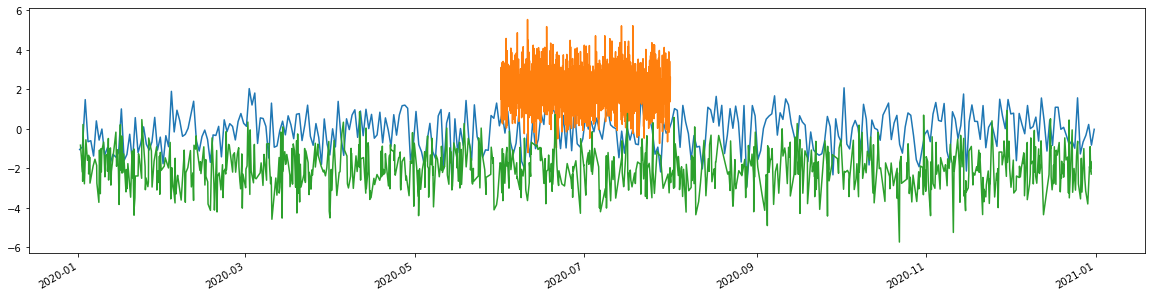

In [16]:
from qa4sm_preprocessing.reading import GriddedNcContiguousRaggedTs

ds = GriddedNcContiguousRaggedTs("pynetcf_soil_moisture")

plt.figure(figsize=(20, 5))
for gpi in range(3):
    df = ds.read(gpi)
    print(df)
    df["soil_moisture"].plot()

Again, the reading of the individual time series reproduced the input data, so after zipping the directory it can be uploaded to QA4SM.